In [1]:

# ✅ Imports
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:

# ✅ Function to prepare data
def prepare_data(data_dir, target_size=(128, 128), batch_size=32, val_split=0.2):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=val_split)
    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )
    val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )
    return train_generator, val_generator


In [4]:

# ✅ Function to build the model
def build_model(input_shape=(128, 128, 3), num_classes=5):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model, base_model


In [16]:

# ✅ Function to train and save progress with callbacks
def train_model(model, train_generator, val_generator, log_dir="logs", checkpoint_path="model_checkpoint.keras", epochs=10):
    callbacks = [
       # tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        #tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    ]
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks
    )
    return history


In [ ]:

# ✅ Function to fine-tune the model
def fine_tune_model(model, base_model, train_generator, val_generator, fine_tune_at=200,
                    log_dir="logs_finetune", checkpoint_path="model_finetuned_checkpoint.keras", initial_epochs=5, fine_tune_epochs=10):
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    total_epochs = initial_epochs + fine_tune_epochs
    callbacks = [
        ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1),
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
        #tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    ]

    history_finetune = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=total_epochs,
        initial_epoch=initial_epochs,
        callbacks=callbacks
    )
    return history_finetune


In [18]:

# ✅ Example pipeline usage
data_dir = r"C:\Users\aboui\Downloads\Dataset"

train_gen, val_gen = prepare_data(data_dir)
model, base_model = build_model()
history = train_model(model, train_gen, val_gen)
history_finetune = fine_tune_model(model, base_model, train_gen, val_gen, initial_epochs=len(history.epoch))


Found 33120 images belonging to 5 classes.
Found 8278 images belonging to 5 classes.
Epoch 1/10
1035/1035 [==============================] - 50s 44ms/step - loss: 1.4980 - accuracy: 0.2475 - val_loss: 1.4881 - val_accuracy: 0.2415
Epoch 2/10
1035/1035 [==============================] - 46s 44ms/step - loss: 1.4926 - accuracy: 0.2428 - val_loss: 1.4903 - val_accuracy: 0.2415
Epoch 3/10
1035/1035 [==============================] - 51s 49ms/step - loss: 1.4919 - accuracy: 0.2488 - val_loss: 1.4887 - val_accuracy: 0.2438
Epoch 4/10
1035/1035 [==============================] - 55s 53ms/step - loss: 1.4895 - accuracy: 0.2527 - val_loss: 1.4811 - val_accuracy: 0.2414
Epoch 5/10
1035/1035 [==============================] - 49s 47ms/step - loss: 1.4871 - accuracy: 0.2607 - val_loss: 1.4787 - val_accuracy: 0.3148
Epoch 6/10
 653/1035 [=================>............] - ETA: 14s - loss: 1.4820 - accuracy: 0.2635

KeyboardInterrupt: 

In [ ]:
# Unfreeze layers from a certain index
unfreeze_from = 100  # adjust this based on previous print
for i, layer in enumerate(model.layers):
    if i >= unfreeze_from:
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile with low learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Resume training
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=1,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("best_model_continued.keras", save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(log_dir="logs_continue")
    ]
)


NameError: name 'train_gen' is not defined

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# Load your saved model
model = load_model("best_model_continued.keras")
print("✅ Model loaded successfully!")


# model.summary()

trainable_count = sum(tf.keras.backend.count_params(w) for w in model.trainable_weights)
non_trainable_count = sum(tf.keras.backend.count_params(w) for w in model.non_trainable_weights)

print(f"🧠 Trainable parameters: {trainable_count:,}")
print(f"🧊 Non-trainable parameters: {non_trainable_count:,}")
print(f"🔢 Total parameters: {trainable_count + non_trainable_count:,}")



✅ Model loaded successfully!
🧠 Trainable parameters: 4,004,961
🧊 Non-trainable parameters: 209,223.0
🔢 Total parameters: 4,214,184.0


In [ ]:
def export_model_summary_and_diagram(model, folder="exports", name="model"):
    import os
    import tensorflow as tf
    from PIL import Image, ImageDraw, ImageFont

    os.makedirs(folder, exist_ok=True)

    # 1. Try saving visual diagram
    architecture_path = os.path.join(folder, f"{name}_architecture.png")
    try:
        from tensorflow.keras.utils import plot_model
        plot_model(model, to_file=architecture_path, show_shapes=True, show_layer_names=True)
        print(f"📐 Architecture image saved to: {architecture_path}")
    except ImportError:
        print("⚠️ You must install `pydot` and `graphviz` to generate the architecture image.")

    # 2. Save model.summary() to TXT file
    summary_txt_path = os.path.join(folder, f"{name}_summary.txt")
    with open(summary_txt_path, "w", encoding="utf-8") as f:
        model.summary(print_fn=lambda x: f.write(x + "\n"))
    print(f"📝 Text summary saved to: {summary_txt_path}")

    # 3. Convert text summary to an image
    with open(summary_txt_path, "r", encoding="utf-8") as file:
        lines = file.readlines()

    font = ImageFont.load_default()
    width = 1000
    height = 15 * len(lines)
    img = Image.new("RGB", (width, height), color="white")
    draw = ImageDraw.Draw(img)

    for i, line in enumerate(lines):
        draw.text((10, i * 15), line.strip(), fill="black", font=font)

    summary_img_path = os.path.join(folder, f"{name}_summary_image.png")
    img.save(summary_img_path)
    print(f"🖼️ Text summary image saved to: {summary_img_path}")


In [ ]:
export_model_summary_and_diagram(model, folder="exports", name="best_model_continued")


You must install pydot (`pip install pydot`) for `plot_model` to work.
📐 Architecture image saved to: exports\best_model_continued_architecture.png


📝 Text summary saved to: exports\best_model_continued_summary.txt
🖼️ Text summary image saved to: exports\best_model_continued_summary_image.png


In [19]:
def evaluate_saved_model_with_confusion(model_path, val_generator, class_names=None, normalize=True):
    import tensorflow as tf
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    # Load model
    model = tf.keras.models.load_model(model_path)
    print(f"✅ Model loaded from {model_path}")

    # Evaluate model
    loss, acc = model.evaluate(val_generator, verbose=0)
    print(f"📊 Accuracy:         {acc * 100:.2f}%")
    print(f"📉 Loss:             {loss:.4f}")

    # Predict and create confusion matrix
    y_true = val_generator.classes
    y_pred_probs = model.predict(val_generator, verbose=0)

    # Handle multi-class or binary
    if y_pred_probs.shape[1] > 1:
        y_pred = np.argmax(y_pred_probs, axis=1)
    else:
        y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

    # Get class names
    if class_names is None:
        class_names = list(val_generator.class_indices.keys())

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    # Display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.gcf().set_size_inches(8, 6)
    plt.title("📌 Matrice de confusion")
    plt.tight_layout()
    plt.show()


✅ Model loaded from ./best_model_continued.keras
📊 Accuracy:         68.03%
📉 Loss:             0.7305


C:\Users\P3mas\AppData\Local\Temp\ipykernel_1428\1512681038.py:40: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\P3mas\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


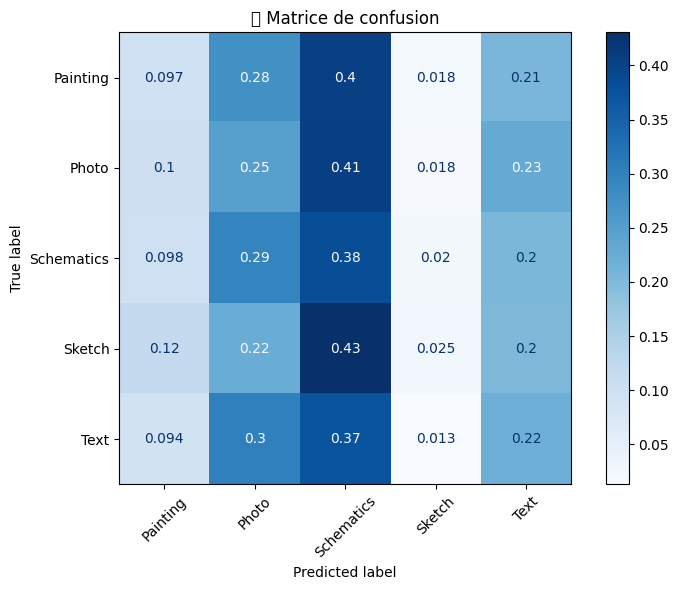

In [20]:
evaluate_saved_model_with_confusion("./best_model_continued.keras", val_gen)
